In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_GroundTruth.csv
/kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_metadata.csv
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035342.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035050.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0034851.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0034920.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035278.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035823.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035733.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035790.jpg
/kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images/ISIC_0035152.jpg
/kaggle/input/skin-cancer-the

0. Setup & Imports

In [3]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.nn.functional import sigmoid

import matplotlib.pyplot as plt

%matplotlib inline

1. Paths to HAM10000 Data

In [6]:

import os

DATA_DIR = "/kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_images_part_1"
DATA_DIR = "/kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_images_part_2"
META_CSV  = "/kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_metadata.csv"

print("DIR 1:", DATA_DIR, os.path.isdir(DATA_DIR))
print("DIR 2:", DATA_DIR, os.path.isdir(DATA_DIR))
print("META:", META_CSV, os.path.isfile(META_CSV))

assert os.path.isdir(DATA_DIR), "Part 1 image directory not found"
assert os.path.isdir(DATA_DIR), "Part 2 image directory not found"
assert os.path.isfile(META_CSV), "Metadata CSV not found"


DIR 1: /kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_images_part_2 True
DIR 2: /kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_images_part_2 True
META: /kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_metadata.csv True


2. Load Metadata and Create Binary Labels

In [7]:
df = pd.read_csv(META_CSV)
print("Original rows:", len(df))
display(df.head())

# Map 7-class dx -> binary risk_label
risk_map = {
    "mel": 1,   # melanoma - high risk
    "bcc": 1,   # basal cell carcinoma - high risk
    "akiec": 1, # actinic keratoses - high risk
    "nv": 0,    # nevus - low risk
    "bkl": 0,   # benign keratosis - low risk
    "df": 0,    # dermatofibroma - low risk
    "vasc": 0   # vascular lesions - low risk
}

df["risk_label"] = df["dx"].map(risk_map)

print("Class counts (full dataset):")
print(df["risk_label"].value_counts())
print("Class ratio (full dataset):")
print(df["risk_label"].value_counts(normalize=True))

Original rows: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


Class counts (full dataset):
risk_label
0    8061
1    1954
Name: count, dtype: int64
Class ratio (full dataset):
risk_label
0    0.804893
1    0.195107
Name: proportion, dtype: float64


3. Filter Missing Images & Duplicates

In [8]:
def image_exists(image_id):
    return os.path.isfile(os.path.join(DATA_DIR, image_id + ".jpg"))

df = df[df["image_id"].apply(image_exists)]
df = df.drop_duplicates(subset="image_id").reset_index(drop=True)

print("Rows after filtering & removing duplicates:", len(df))

Rows after filtering & removing duplicates: 5015


4. Optional Subset (for faster training in class)

In [9]:
print("Dataset before subset:", len(df))
N_PER_CLASS = 800  

subset_df = (
    df.groupby("risk_label", group_keys=False)
      .apply(lambda g: g.sample(n=min(N_PER_CLASS, len(g)), random_state=42))
      .reset_index(drop=True)
)

print("Subset size:", len(subset_df))
print(subset_df["risk_label"].value_counts())


Dataset before subset: 5015
Subset size: 1600
risk_label
0    800
1    800
Name: count, dtype: int64


/tmp/ipykernel_47/2932843245.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(N_PER_CLASS, len(g)), random_state=42))


5. Train / Val / Test Split (Stratified)

In [10]:
train_df, temp_df = train_test_split(
    subset_df,
    test_size=0.30,
    stratify=subset_df["risk_label"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["risk_label"],
    random_state=42,
)

print("Train:", len(train_df))
print("Val:  ", len(val_df))
print("Test: ", len(test_df))

Train: 1120
Val:   240
Test:  240


6. EDA: Class Distribution Plots

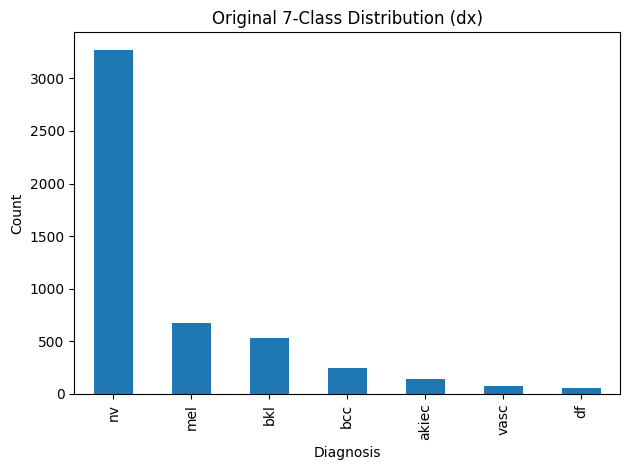

In [11]:
# Figure 1: Original 7-class distribution
plt.figure()
df["dx"].value_counts().plot(kind="bar")
plt.title("Original 7-Class Distribution (dx)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

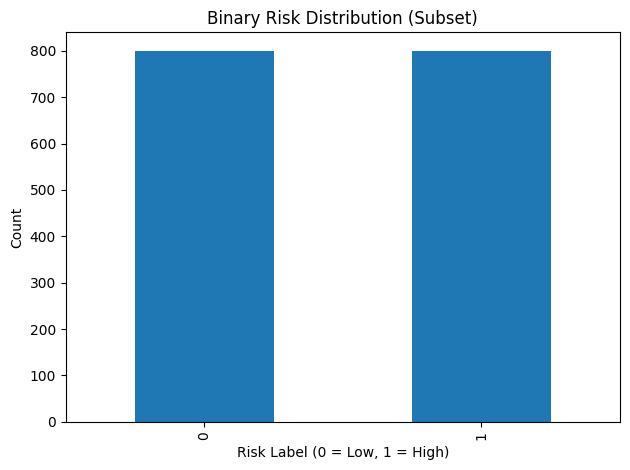

In [12]:
# Figure 2: Binary risk distribution
plt.figure()
subset_df["risk_label"].value_counts().plot(kind="bar")
plt.title("Binary Risk Distribution (Subset)")
plt.xlabel("Risk Label (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [14]:
# برای نمونه چند تصویر از high-risk و low-risk
def show_examples(example_df, title, n=6):
    sample = example_df.sample(n=min(n, len(example_df)), random_state=0)
    plt.figure(figsize=(10, 4))
    for i, (_, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(DATA_DIR, row["image_id"] + ".jpg")
        img = Image.open(img_path).convert("RGB")
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{row['dx']} (risk={row['risk_label']})")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

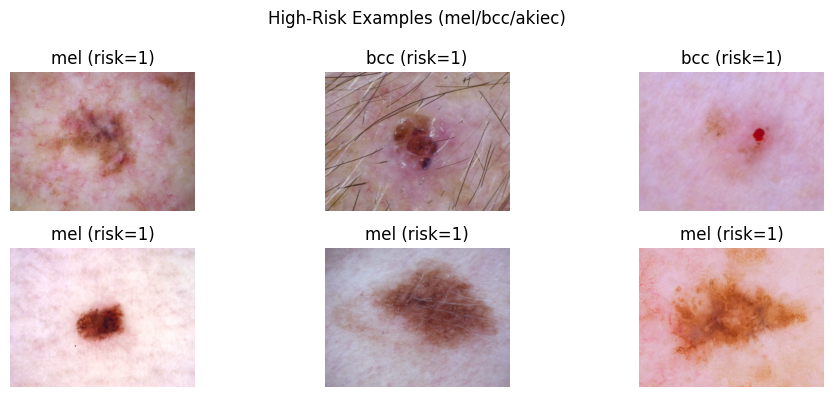

In [15]:
# Figure 3: High-risk examples
show_examples(subset_df[subset_df["risk_label"]==1], "High-Risk Examples (mel/bcc/akiec)", n=6)

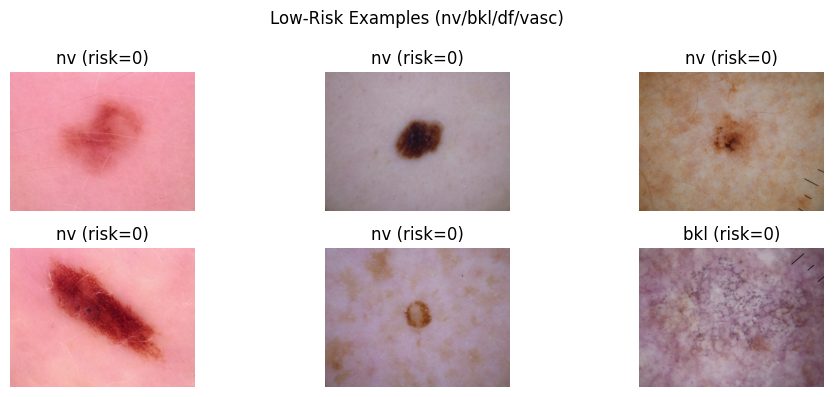

In [16]:
# Figure 4: Low-risk examples
show_examples(subset_df[subset_df["risk_label"]==0], "Low-Risk Examples (nv/bkl/df/vasc)", n=6)


7. PyTorch Dataset & DataLoaders

In [17]:
IMG_SIZE = 160
BATCH_SIZE = 16

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class HamDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row["risk_label"], dtype=torch.float32)
        return image, label

train_dataset = HamDataset(train_df, DATA_DIR, train_transform)
val_dataset   = HamDataset(val_df, DATA_DIR, eval_transform)
test_dataset  = HamDataset(test_df, DATA_DIR, eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


8. Device (GPU if available)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


9. Define Model (ResNet-18)

In [19]:
#model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
#model.fc = nn.Linear(model.fc.in_features, 1)
#model = model.to(device)
#print(model.fc)


model = models.resnet18(weights=None)  # No pretrained weights
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

10. Loss Function with Class Weighting

In [20]:
train_counts = Counter(train_df["risk_label"])
print("Train counts:", train_counts)

# pos_weight = (# negative / # positive)
pos_weight_value = train_counts[0] / max(train_counts[1], 1)
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_value], device=device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 6

print("pos_weight_value:", pos_weight_value)

Train counts: Counter({1: 560, 0: 560})
pos_weight_value: 1.0


11. Training & Evaluation Helpers

In [21]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images).squeeze(1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = (sigmoid(logits) >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_prob = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images).squeeze(1)
            loss = criterion(logits, labels)
            running_loss += loss.item() * labels.size(0)

            probs = sigmoid(logits)
            preds = (probs >= 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    
    return running_loss / total, correct / total, np.array(y_true), np.array(y_prob)

12. Training Loop

In [22]:
best_val_loss = float("inf")
train_history = []
val_history = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    train_history.append((train_loss, train_acc))
    val_history.append((val_loss, val_acc))
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/best_resnet18_triage.pth")

# Load best model
model.load_state_dict(torch.load("/content/best_resnet18_triage.pth", map_location=device))


Epoch 1/6 Train Loss: 0.6372 Acc: 0.6241 Val Loss: 0.5631 Acc: 0.6833
Epoch 2/6 Train Loss: 0.5723 Acc: 0.6902 Val Loss: 0.6015 Acc: 0.6667
Epoch 3/6 Train Loss: 0.5692 Acc: 0.6875 Val Loss: 0.5359 Acc: 0.6833
Epoch 4/6 Train Loss: 0.5508 Acc: 0.7054 Val Loss: 0.5119 Acc: 0.7042
Epoch 5/6 Train Loss: 0.5272 Acc: 0.7241 Val Loss: 0.5624 Acc: 0.6750
Epoch 6/6 Train Loss: 0.5482 Acc: 0.6964 Val Loss: 0.5425 Acc: 0.7333


<All keys matched successfully>

13. Plot Training Curves (Figures 5 & 6)

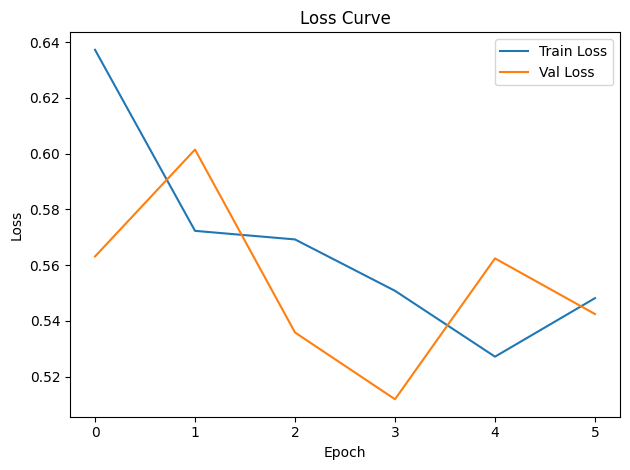

In [25]:
train_losses = [x[0] for x in train_history]
val_losses   = [x[0] for x in val_history]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

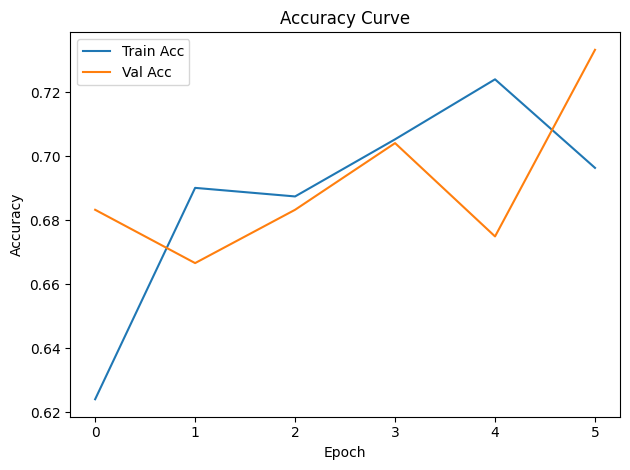

In [26]:
train_accs = [x[1] for x in train_history]
val_accs   = [x[1] for x in val_history]

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

14. Test Evaluation, Confusion Matrix, ROC (Figures 7 & 8)

Test Loss: 0.47763620416323344
Test Accuracy: 0.7458333333333333
              precision    recall  f1-score   support

    Low Risk       0.84      0.61      0.71       120
   High Risk       0.69      0.88      0.78       120

    accuracy                           0.75       240
   macro avg       0.77      0.75      0.74       240
weighted avg       0.77      0.75      0.74       240



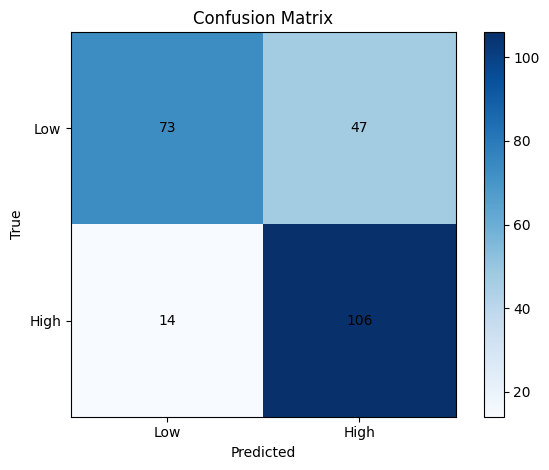

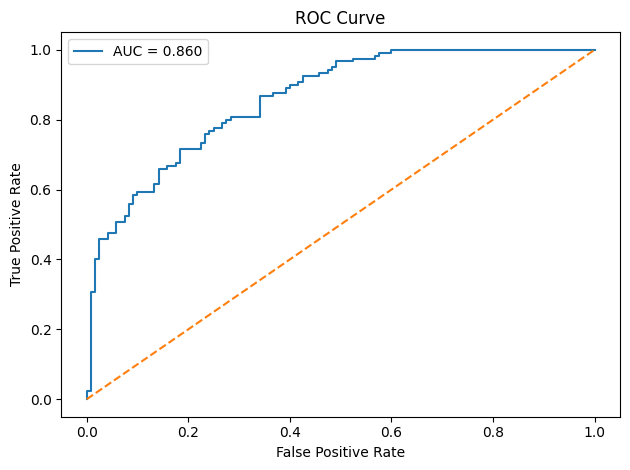

In [24]:
test_loss, test_acc, y_true, y_prob = evaluate(model, test_loader, criterion, device)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_true, y_pred, target_names=["Low Risk", "High Risk"]))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Low", "High"])
ax.set_yticklabels(["Low", "High"])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

roc_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


15. Simple Grad-CAM for Interpretability (for a few examples)

In [28]:
# Grad-CAM implementation adapted for ResNet-18

from torchvision.transforms.functional import to_pil_image

class GradCAM:
    def __init__(self, model, target_layer_name="layer4"):
        self.model = model
        self.model.eval()
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.gradients = None
        self.activations = None
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate(self, input_tensor):
        self.model.zero_grad()
        logits = self.model(input_tensor)
        # assume binary classification, take logit for class 1 (high-risk)
        score = logits[:, 0]
        score.backward(retain_graph=True)
        
        gradients = self.gradients  # [B, C, H, W]
        activations = self.activations  # [B, C, H, W]
        
        alpha = gradients.mean(dim=(2, 3), keepdim=True)
        weighted = (alpha * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(weighted)
        
        cam = cam.squeeze(0).squeeze(0).detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

grad_cam = GradCAM(model, target_layer_name="layer4")


In [29]:
# انتخاب چند نمونه از test set برای Grad-CAM
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [30]:
def show_gradcam_example(dataset, index):
    image, label = dataset[index]
    input_tensor = image.unsqueeze(0).to(device)
    
    cam = grad_cam.generate(input_tensor)
    
    # تصویر اصلی (denorm)
    img_denorm = inv_normalize(image)
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Original (label={int(label.item())})")
    
    plt.subplot(1,2,2)
    plt.imshow(img_np)
    plt.imshow(cam, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap (High-Risk Logit)")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


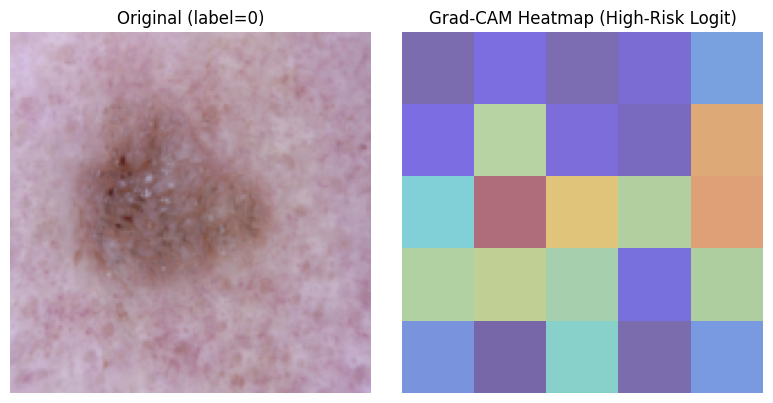

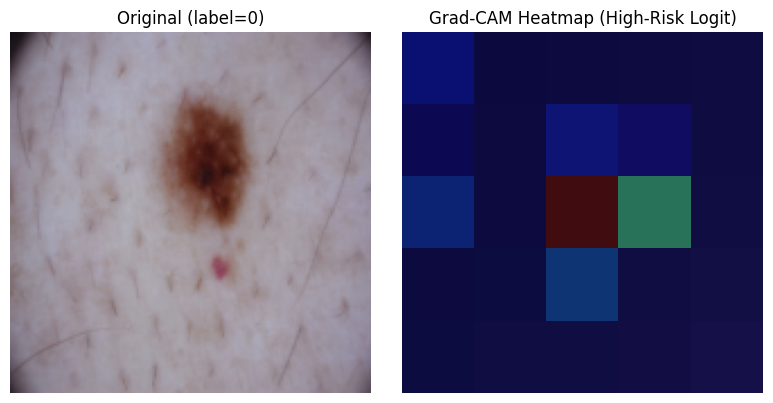

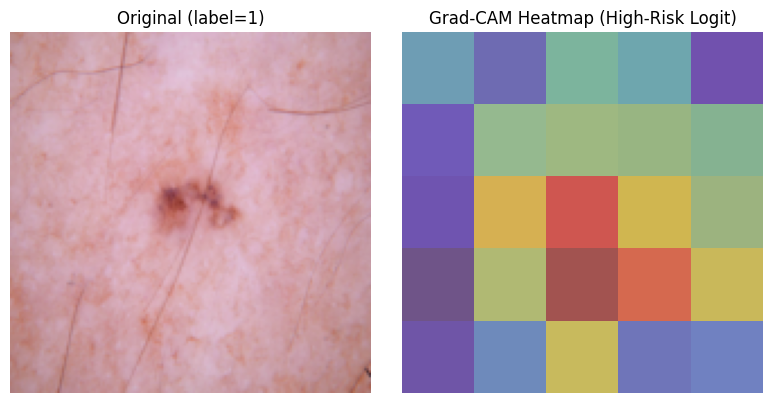

In [31]:
# Several Sampel
show_gradcam_example(test_dataset, 0)
show_gradcam_example(test_dataset, 1)
show_gradcam_example(test_dataset, 2)